In [1]:
import torch
from torch.nn import functional as F
from matplotlib import pyplot as plt

## Load Data

In [2]:
!wget https://raw.githubusercontent.com/ncarkaci/TDKDictionaryCrawler/master/ortak_kelimeler.txt

--2024-06-25 19:55:54--  https://raw.githubusercontent.com/ncarkaci/TDKDictionaryCrawler/master/ortak_kelimeler.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 402869 (393K) [text/plain]
Saving to: ‘ortak_kelimeler.txt’

ortak_kelimeler.txt 100%[===================>] 393.43K  --.-KB/s    in 0.1s    

2024-06-25 19:55:55 (3.36 MB/s) - ‘ortak_kelimeler.txt’ saved [402869/402869]



In [3]:
with open("ortak_kelimeler.txt") as f:
    text = f.read()

In [4]:
words = text.split("\n")

In [5]:
long_text = text.replace("\n","")
ids = list(set(long_text))
len(ids)

29

In [6]:
ordinal_char_pairs = sorted([(ord(c),c) for c in ids])
ordinal_char_pairs

[(97, 'a'),
 (98, 'b'),
 (99, 'c'),
 (100, 'd'),
 (101, 'e'),
 (102, 'f'),
 (103, 'g'),
 (104, 'h'),
 (105, 'i'),
 (106, 'j'),
 (107, 'k'),
 (108, 'l'),
 (109, 'm'),
 (110, 'n'),
 (111, 'o'),
 (112, 'p'),
 (114, 'r'),
 (115, 's'),
 (116, 't'),
 (117, 'u'),
 (118, 'v'),
 (121, 'y'),
 (122, 'z'),
 (231, 'ç'),
 (246, 'ö'),
 (252, 'ü'),
 (287, 'ğ'),
 (305, 'ı'),
 (351, 'ş')]

## Encode & Decode Functions

In [7]:
ctoi = {c:i for i,(o,c) in enumerate(ordinal_char_pairs)}
itoc =  {i:c for i,(o,c) in enumerate(ordinal_char_pairs)}

In [8]:
ctoi['.']=len(ctoi)
itoc[len(itoc)]='.'

In [9]:
def encode(input:str):
    return [ctoi[c] for c in input]

def decode(ids):
    return "".join([itoc[i] for i in ids])

In [10]:
assert decode(encode("zemberek"))=='zemberek'

## Prepare Training Data

In [11]:
xs, ys = [], []
for w in words:
    w = "."+w+"."
    for c1, c2 in zip(w, w[1:]):
        ix = ctoi[c1]
        iy = ctoi[c2]

        xs.append(ix)
        ys.append(iy)
xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [12]:
xs.shape

torch.Size([367078])

In [13]:
xs[:10] ,ys[:10]

(tensor([29,  0,  1,  0, 29,  0,  1,  0,  2, 27]),
 tensor([ 0,  1,  0, 29,  0,  1,  0,  2, 27, 29]))

## Helpers

In [14]:
import abc


class BaseBiGram(abc.ABC):

    @abc.abstractmethod
    def forward(self, xs):
        pass

    def __call__(self, xs):
        return self.forward(xs)

    @abc.abstractmethod
    def train(self, xs, ys):
        pass

    def generate(self):
        ids = []
        special = ctoi['.']
        ix = special
        while True:
            ix = torch.multinomial(self.forward(ix), num_samples=1, replacement=True).item()
            if ix == special:
                break
            ids.append(ix)

        return decode(ids)

## Count Based

In [15]:
T = torch.zeros([30, 30], dtype=torch.int32)

In [16]:
probs = T / T.sum(dim=1, keepdim=True)

In [18]:
class CountBiGram(BaseBiGram):
    def __init__(self):
        self.probs = None,

    def forward(self, ix):
        return self.probs[ix]

    def train(self, xs, ys):
        T = torch.zeros([30, 30], dtype=torch.int32)

        for ix, iy in zip(xs, ys):
            T[ix][iy] += 1

        self.probs = T / T.sum(dim=1, keepdim=True)

        loss = -self.probs[xs, ys].log().mean()
        print(f"loss: {loss.item():.4f}")



In [19]:
bg = CountBiGram()

In [20]:
bg.train(xs,ys)

loss: 2.5226


## Neural Net Based

In [27]:
class NeuralBiGram(BaseBiGram):
    def __init__(self):
        self.W = None

        # for logging
        self.losses = None
        self.grads = None

    def forward(self, ix):
        ixs = ix if isinstance(ix, list) else [ix]

        # Following two approaches are similar, second option is m ore efficient

        # Option 1 - use one hot vectors and matrix multiplication to get the logits
        # xenc = F.one_hot(xs, num_classes=30).float()
        # logits = xenc @ W  # log counts

        # Option 2 - use array indexing to get the logits
        logits = self.W[ixs] # log counts

        # Softmax
        counts = logits.exp()
        probs = counts / counts.sum(1, keepdim=True)

        return probs

    def train(self, xs, ys):
        self.losses = []
        self.grads = []

        self.W = torch.rand((30, 30), requires_grad=True)
        W = self.W

        for i in range(1000):
            probs = self.forward(xs)

            # negative log likelihood
            loss = -probs[torch.arange(len(xs)), ys].log().mean()

            if i % 10 == 0:
                print(f"Step {i} | loss: {loss.item():.4f}")

            # backward
            W.grad = None
            loss.backward()

            # update weights
            W.data += -10 * W.grad

            # logging
            self.losses.append(loss.item())
            self.grads.append(W.grad)

        print(f"loss: {loss.item():.4f}")

In [28]:
nn = NeuralBiGram()

In [29]:
nn.train(xs,ys)

Step 0 | loss: 3.4309
Step 10 | loss: 3.0891
Step 20 | loss: 2.9236
Step 30 | loss: 2.8338
Step 40 | loss: 2.7763
Step 50 | loss: 2.7362
Step 60 | loss: 2.7067
Step 70 | loss: 2.6842
Step 80 | loss: 2.6664
Step 90 | loss: 2.6521
Step 100 | loss: 2.6402
Step 110 | loss: 2.6303
Step 120 | loss: 2.6219
Step 130 | loss: 2.6146
Step 140 | loss: 2.6083
Step 150 | loss: 2.6028
Step 160 | loss: 2.5979
Step 170 | loss: 2.5935
Step 180 | loss: 2.5896
Step 190 | loss: 2.5861
Step 200 | loss: 2.5829
Step 210 | loss: 2.5800
Step 220 | loss: 2.5774
Step 230 | loss: 2.5750
Step 240 | loss: 2.5727
Step 250 | loss: 2.5707
Step 260 | loss: 2.5688
Step 270 | loss: 2.5670
Step 280 | loss: 2.5654
Step 290 | loss: 2.5638
Step 300 | loss: 2.5624
Step 310 | loss: 2.5611
Step 320 | loss: 2.5598
Step 330 | loss: 2.5586
Step 340 | loss: 2.5575
Step 350 | loss: 2.5565
Step 360 | loss: 2.5555
Step 370 | loss: 2.5545
Step 380 | loss: 2.5537
Step 390 | loss: 2.5528
Step 400 | loss: 2.5520
Step 410 | loss: 2.5512
Ste

### Plot training details

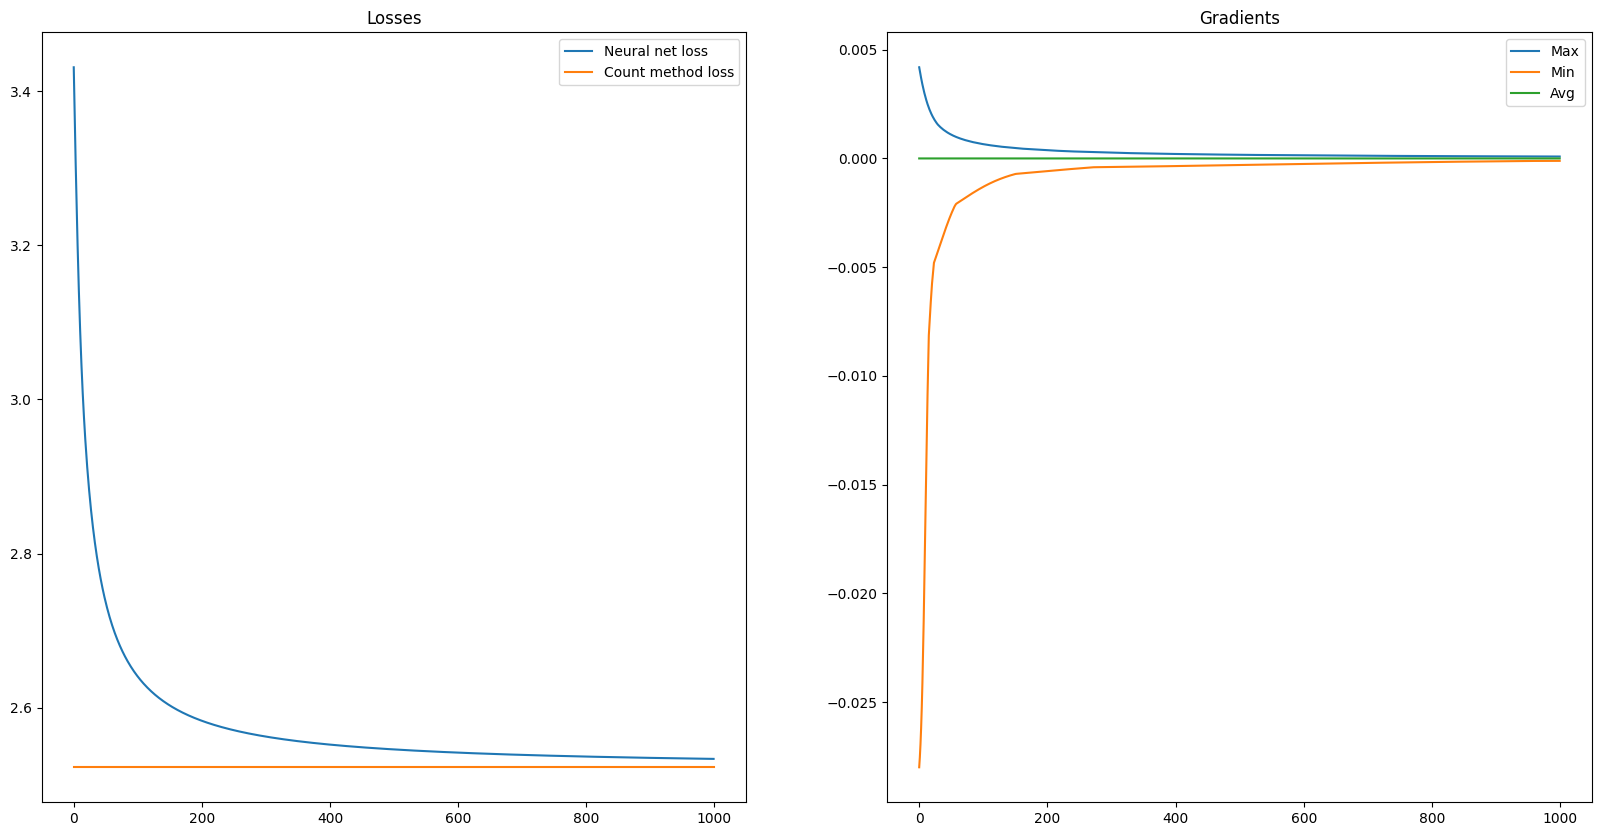

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))


axs[0].plot(nn.losses, label="Neural net loss")
axs[0].plot([0, 1000],[2.5226,2.5226], label="Count method loss")
axs[0].set_title('Losses')
axs[0].legend()

axs[1].plot([g.max() for g in nn.grads], label="Max")
axs[1].plot([g.min() for g in nn.grads], label="Min")
axs[1].plot([g.mean() for g in nn.grads], label="Avg")
axs[1].set_title('Gradients')
axs[1].legend()

plt.show()

## Generate

In [346]:
torch.manual_seed(35)
for i in range(10):
    print(bg.generate())

atettı
ik
öncırısörarsı
kakl
satsabiçinorekom
bil
stlllıdaşapek
k
s
ir


In [347]:
torch.manual_seed(35)
for i in range(10):
    print(nn.generate())

atettı
ik
öncırısörarsı
kakl
satsabiçinorekom
bil
stlllıdaşapzk
k
s
ir
